In [1]:
# Import packages
import sys
sys.path.insert(0, '/home/ec2-user/SageMaker/model monitor/')

import pandas as pd

import numpy as np

import matplotlib.pyplot as plt

%matplotlib inline

# !pip install xgboost==0.90
# !pip install scorecardpy


In [2]:
#read in the csv model development data
df=pd.read_csv('s3://mf-ml-ds/gen3_model/source/gen3_dev.csv')
df.shape

(428508, 85)

In [3]:
df.loc[df['final_bad_perf'] == 0, 'good_perf'] = 1
df.loc[df['final_bad_perf'] == 1, 'good_perf'] = 0

In [4]:
df['good_perf'].value_counts()

1.0    337974
0.0     90534
Name: good_perf, dtype: int64

In [5]:
df=df.drop(['final_bad_perf'], axis=1)

In [6]:

import scorecardpy as sc
#filter variable via missing rate, iv, identcal value rate
# dt_s=sc.var_filter(df, y='fund_flag', iv_limit=0.01,missing_limit = 0.95, identical_limit = 0.95)

bins=sc.woebin(df, y="good_perf")

[INFO] creating woe binning ...
Binning on 428508 rows and 85 columns in 00:01:53


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/scorecardpy/woebin.py:1203: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax1 = plt.subplots()
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/scorecardpy/woebin.py:1203: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax1 = plt.subplots()
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/scorecardpy/woebin.py:1203: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figu

{'AMS3435': <Figure size 432x288 with 2 Axes>,
 'ATTR_6503': <Figure size 432x288 with 2 Axes>,
 'AMS3797': <Figure size 432x288 with 2 Axes>,
 'AMS3017': <Figure size 432x288 with 2 Axes>,
 'AMS3215': <Figure size 432x288 with 2 Axes>,
 'AMS3002': <Figure size 432x288 with 2 Axes>,
 'archiveattribute24': <Figure size 432x288 with 2 Axes>,
 'AMS3924': <Figure size 432x288 with 2 Axes>,
 'archiveattribute10': <Figure size 432x288 with 2 Axes>,
 'AMS3031': <Figure size 432x288 with 2 Axes>,
 'TDA18625': <Figure size 432x288 with 2 Axes>,
 'AMS3276': <Figure size 432x288 with 2 Axes>,
 'AMS3480': <Figure size 432x288 with 2 Axes>,
 'AMS3962': <Figure size 432x288 with 2 Axes>,
 'RegZ6021': <Figure size 432x288 with 2 Axes>,
 'AMS3392': <Figure size 432x288 with 2 Axes>,
 'ATTR_6633': <Figure size 432x288 with 2 Axes>,
 'ATTR_6646': <Figure size 432x288 with 2 Axes>,
 'TDA04553': <Figure size 432x288 with 2 Axes>,
 'AMS3101': <Figure size 432x288 with 2 Axes>,
 'AMS3191': <Figure size 432x

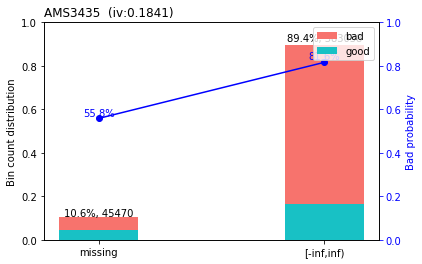

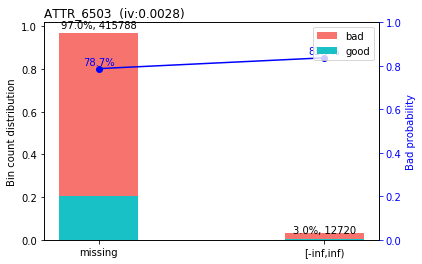

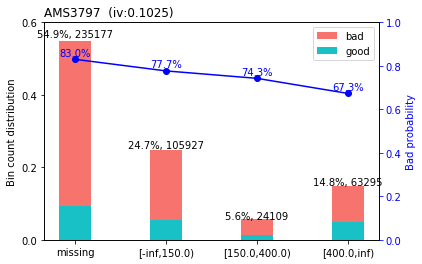

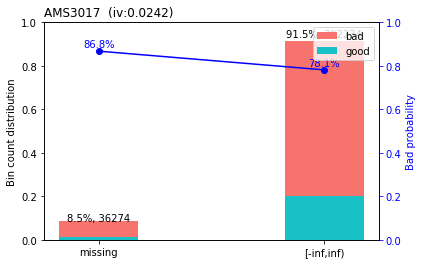

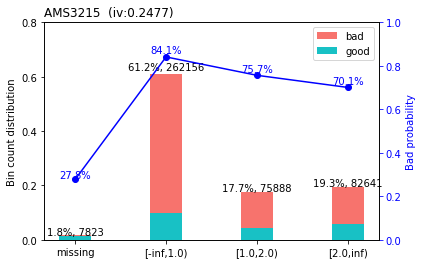

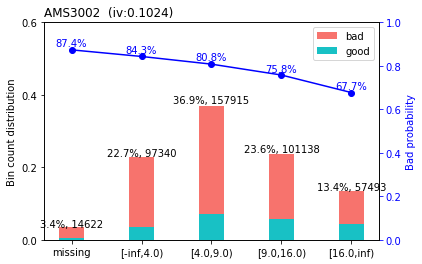

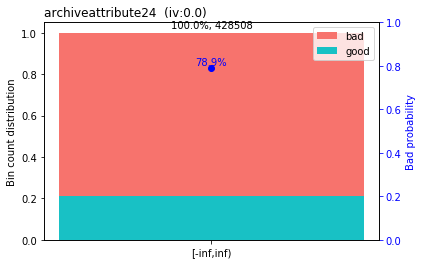

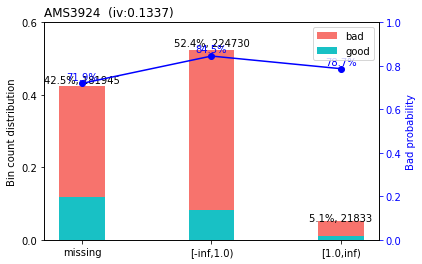

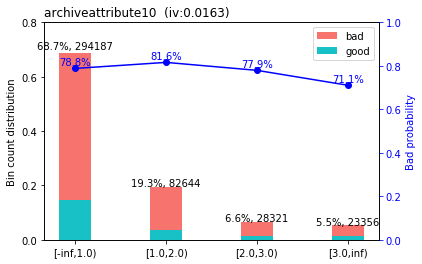

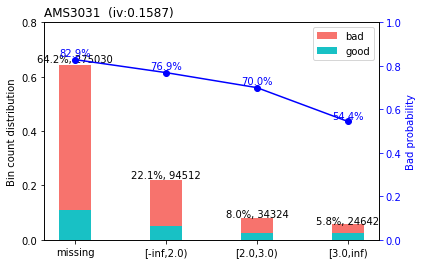

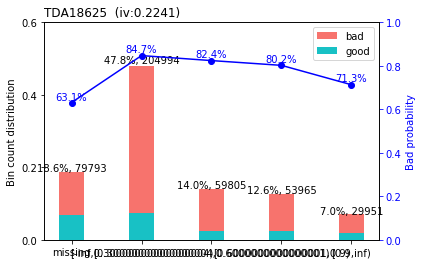

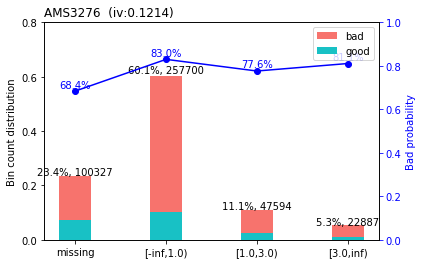

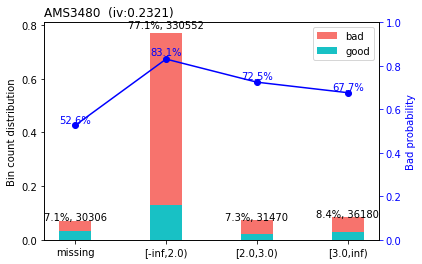

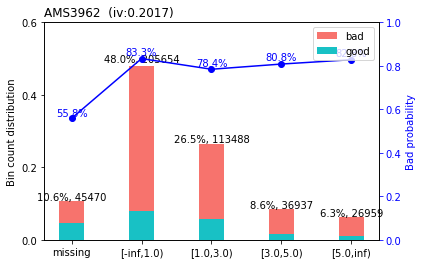

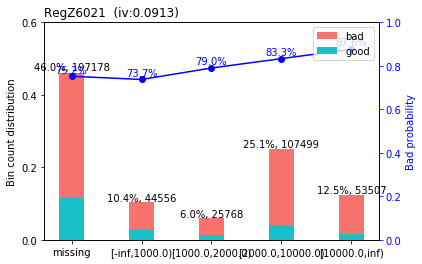

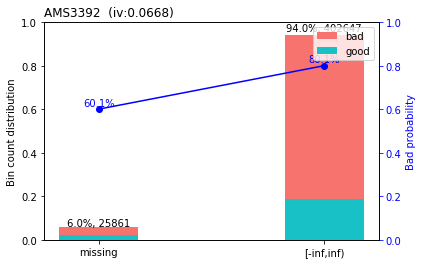

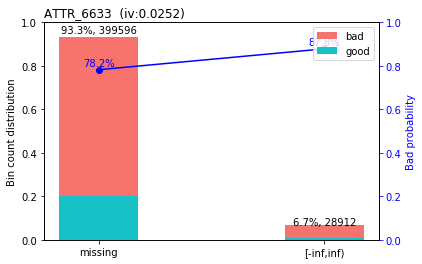

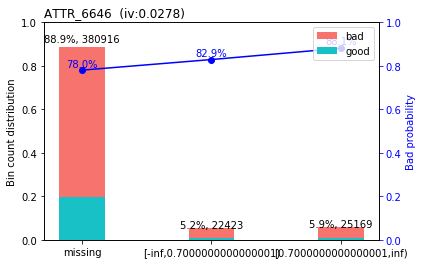

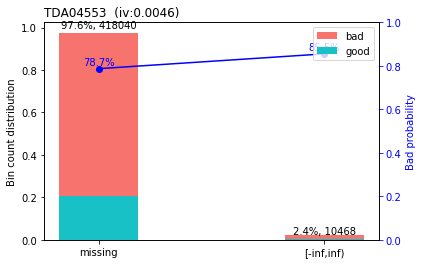

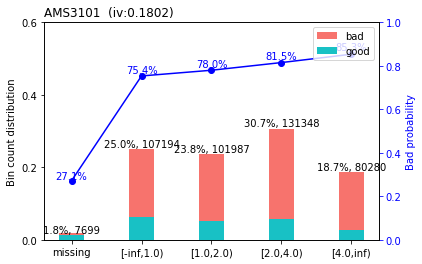

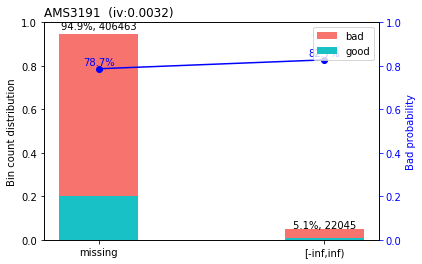

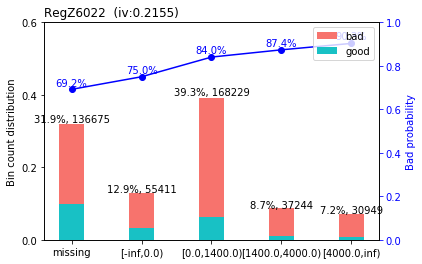

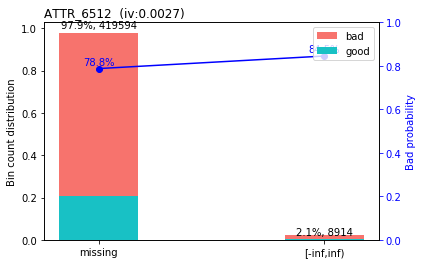

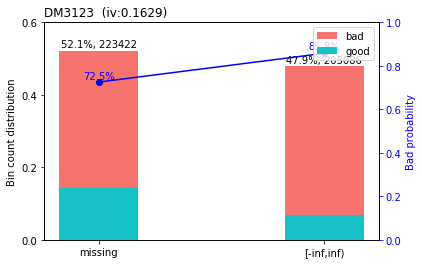

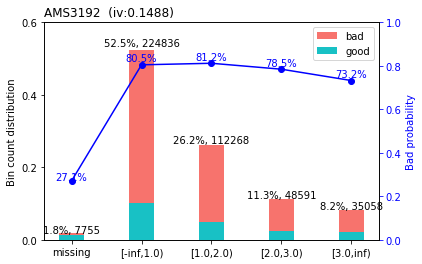

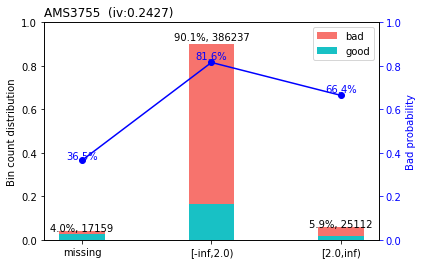

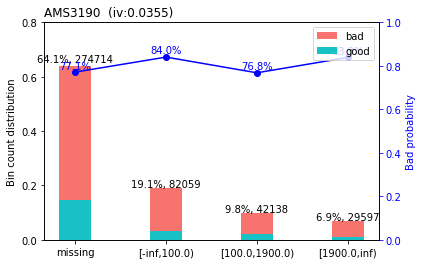

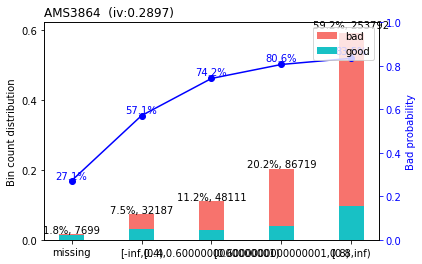

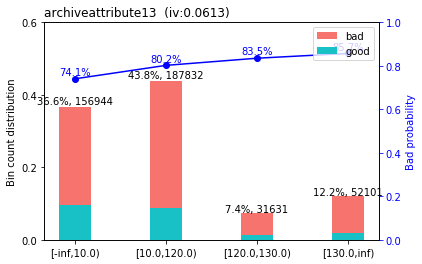

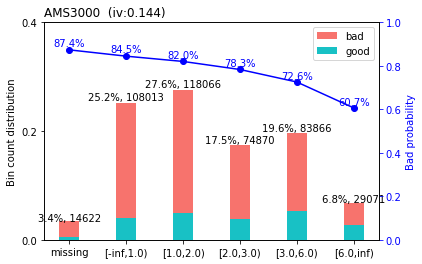

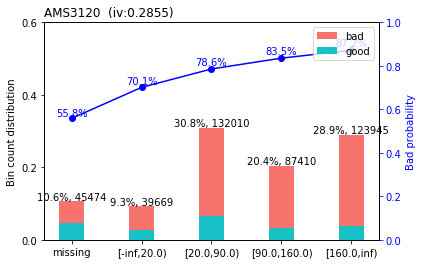

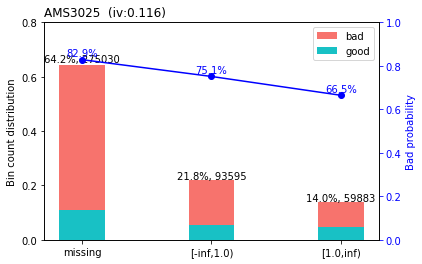

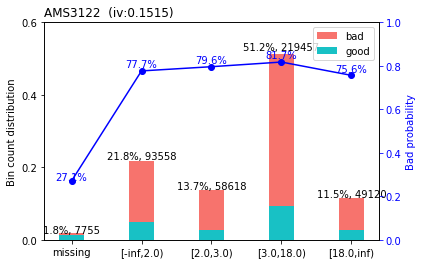

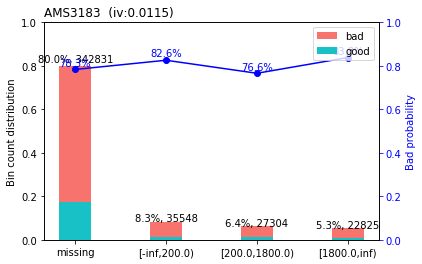

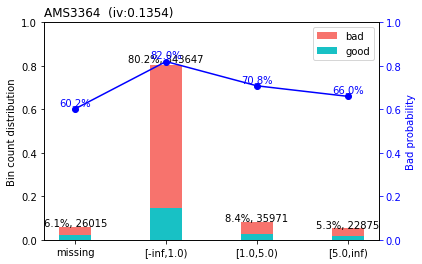

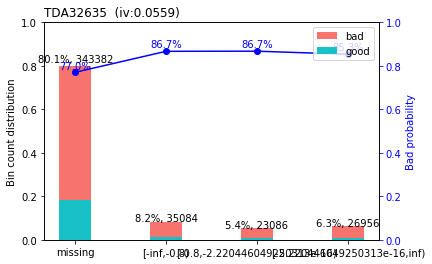

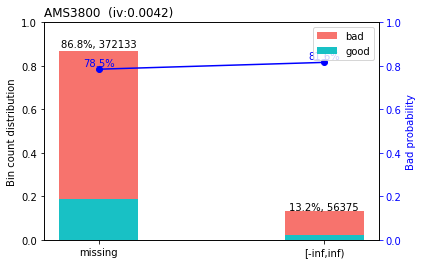

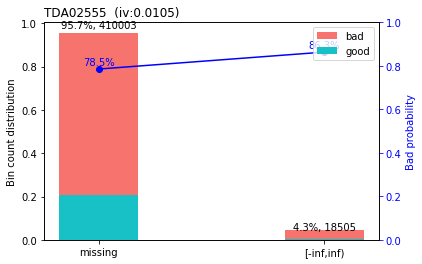

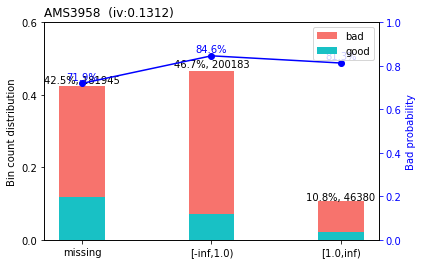

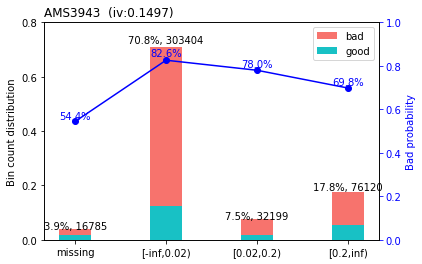

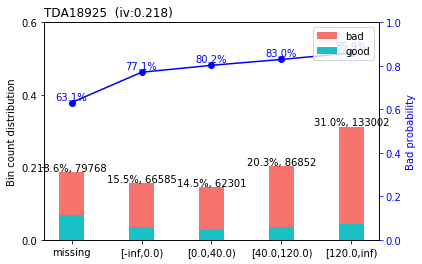

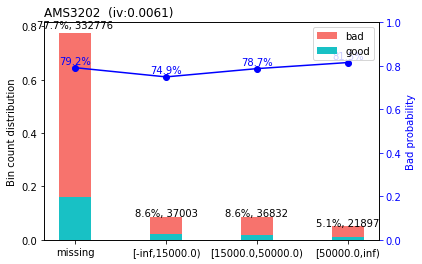

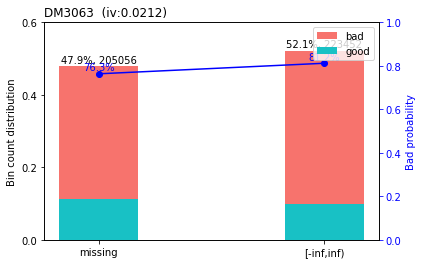

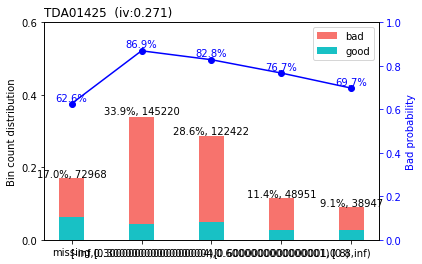

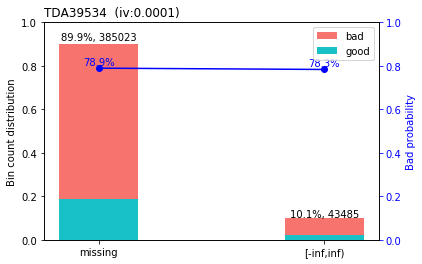

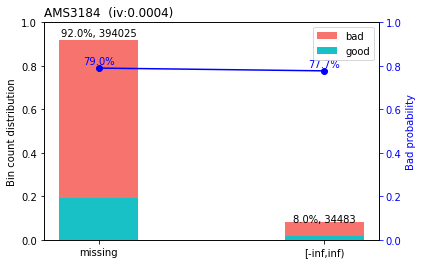

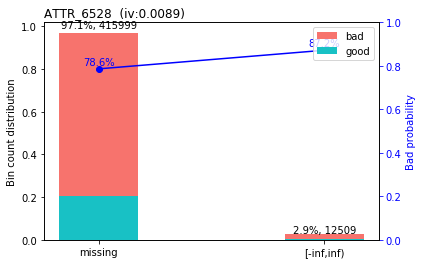

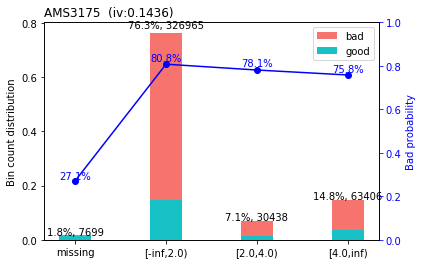

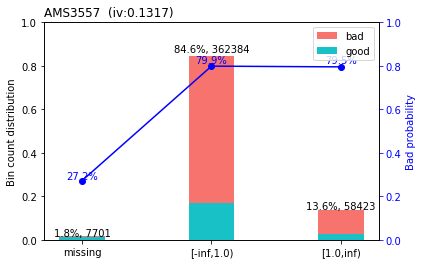

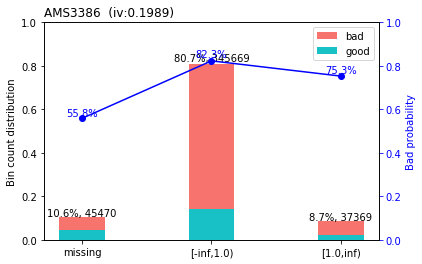

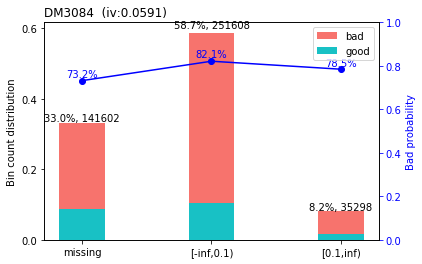

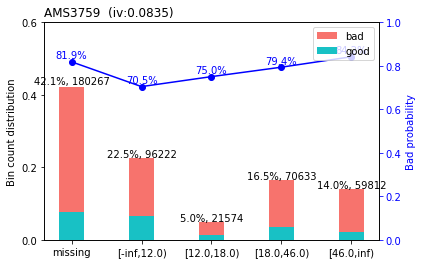

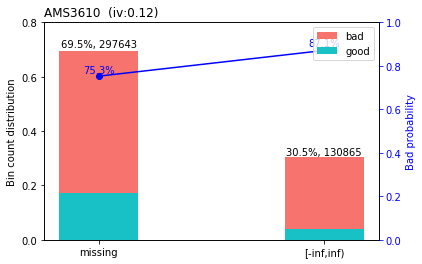

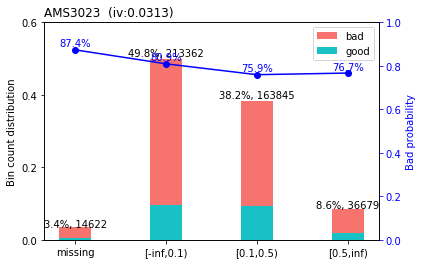

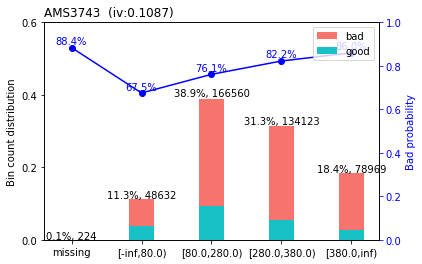

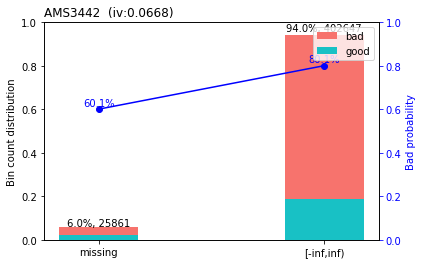

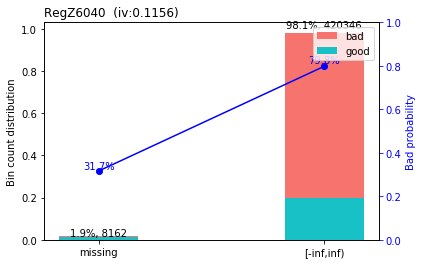

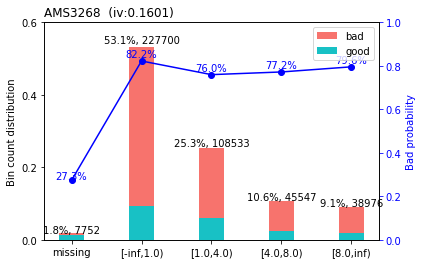

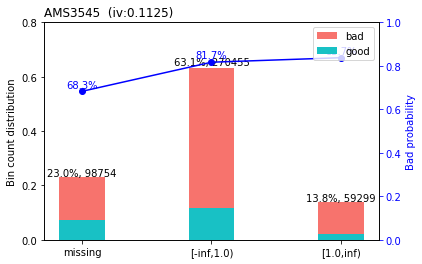

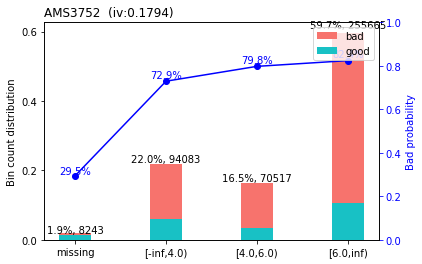

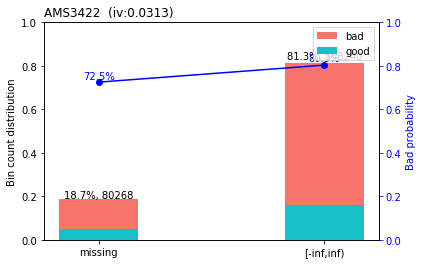

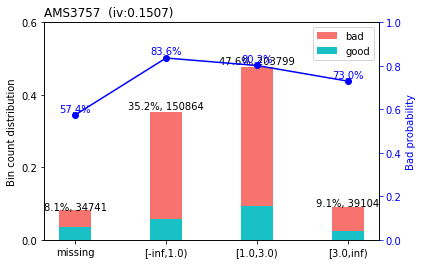

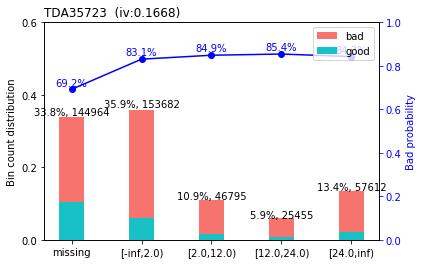

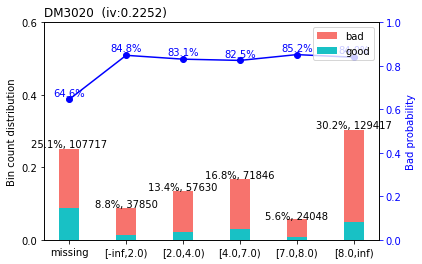

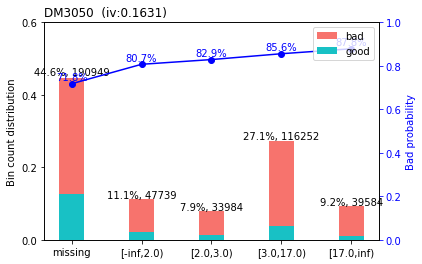

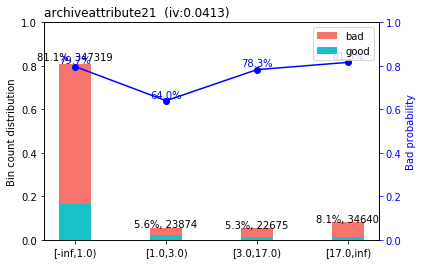

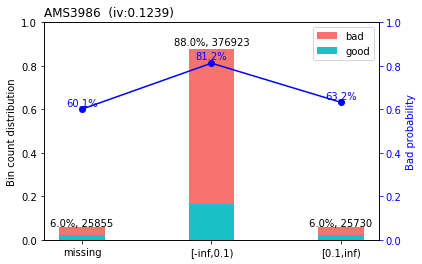

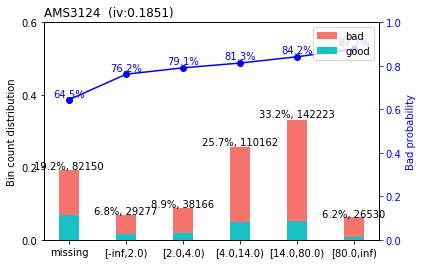

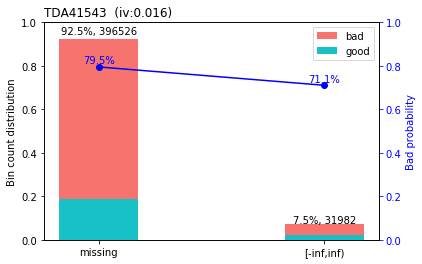

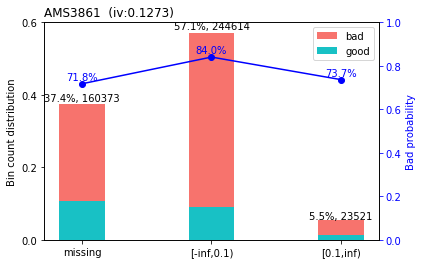

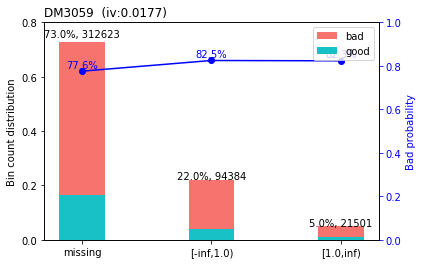

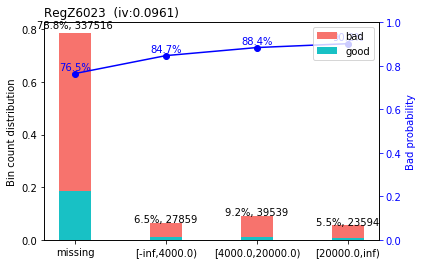

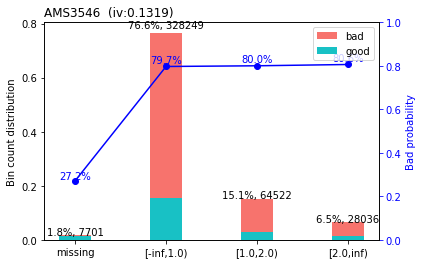

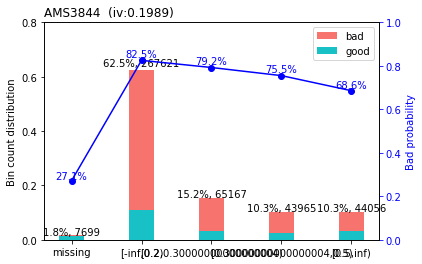

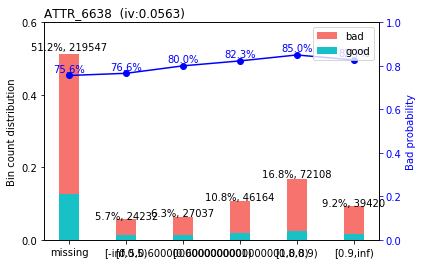

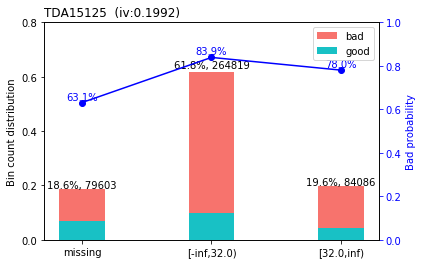

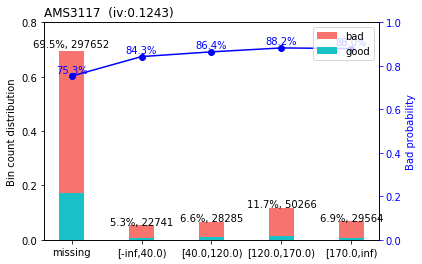

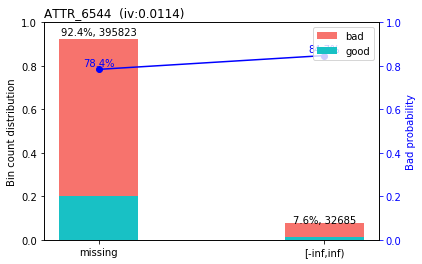

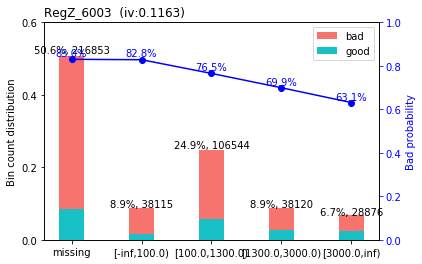

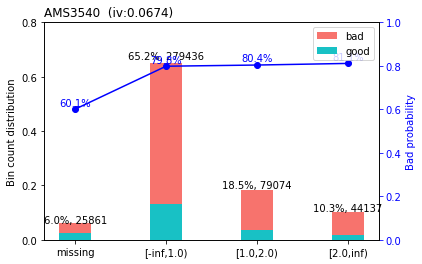

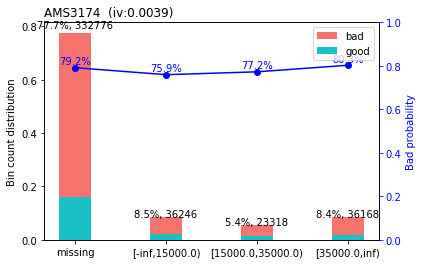

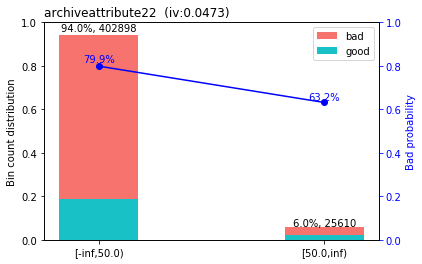

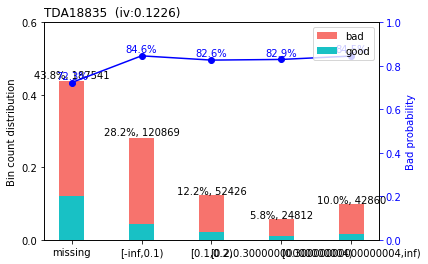

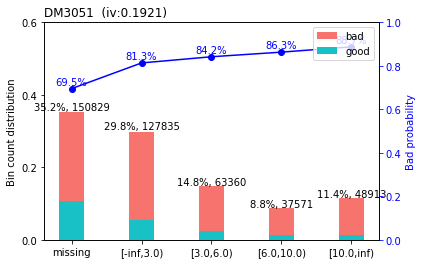

In [7]:
sc.woebin_plot(bins)

In [6]:
# impute all the missing value with 0
df=df.fillna(0)

In [12]:
#check the mean of each variable by the group by bad performance variable
df.groupby('good_perf').mean()


,archiveattribute10,archiveattribute13,archiveattribute21,archiveattribute22,archiveattribute24,AMS3000,AMS3002,AMS3017,AMS3023,AMS3025,...,DM3051,DM3059,DM3063,DM3084,DM3123,RegZ_6003,RegZ6021,RegZ6022,RegZ6023,RegZ6040
good_perf,,,,,,,,,,,,,,,,,,,,,
0.0,0.650673,44.665407,3.398756,173.253606,0.046723,2.677977,10.590176,0.017084,0.168048,0.323315,...,2.155632,0.052489,0.046027,0.029770,0.032330,1298.796684,2350.719962,522.015663,1199.424504,524.344235
1.0,0.540018,57.494745,3.994242,115.028822,0.073577,1.720097,7.969853,0.009489,0.142030,0.145221,...,3.790451,0.064591,0.051465,0.024011,0.050451,672.756017,3953.473353,1293.419526,3712.329333,1303.355726


In [7]:
#split the model development sample into train and test sample
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test=train_test_split(df.drop(['good_perf'], axis='columns'), df.good_perf, test_size=0.3)

In [8]:
from xgboost import XGBClassifier

XGB=XGBClassifier(n_estimators=100, min_samples_leaf=5, class_weight="balanced_subsample", randomstate=42)
XGB.fit(X_train, y_train)

XGB.score(X_test,y_test)



0.8150412670260515

In [15]:
#check VIF
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
X=add_constant(X_train)
X_vif=pd.Series([variance_inflation_factor(X.values, i) for i in range(X.shape[1])], index= X.columns)

In [16]:
df_vif=pd.DataFrame(data=X_vif)
df_vif.to_excel('xgb_vif.xlsx')

In [9]:
#drop two variables that has a higher than 10 vif value
X_train2=X_train.drop(["AMS3202","archiveattribute24","AMS3610","AMS3800","DM3123"], axis=1)
X_test2=X_test.drop(["AMS3202","archiveattribute24","AMS3610","AMS3800","DM3123"], axis=1)

#no variables need to be dropped
# X_train2=X_train
# X_test2=X_test

In [10]:
XGB.fit(X_train2, y_train)

XGB.score(X_test2,y_test)

0.8150412670260515

In [11]:
#use ols to check the P value
import statsmodels.api as sm

#fit the final model

X_final=sm.add_constant(X_train2)
model_final=sm.OLS(y_train, X_final).fit()
model_final.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              good_perf   R-squared:                       0.133
Model:                            OLS   Adj. R-squared:                  0.133
Method:                 Least Squares   F-statistic:                     584.7
Date:                Tue, 14 Sep 2021   Prob (F-statistic):               0.00
Time:                        12:38:24   Log-Likelihood:            -1.3514e+05
No. Observations:              299955   AIC:                         2.704e+05
Df Residuals:                  299875   BIC:                         2.713e+05
Df Model:                          79                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.4971      0.004    132.504      0.000       0.490       0.504
archiveattribute10    -0.0154      0.001    -20.879      0.000      -0.017      -0.014
archiveattribute13  6.054e-05    1.4e-05      4.314      0.000     3.3e-05    8.81e-05
archiveattribute21     0.0003   6.06e-05      5.487      0.000       0.000       0.000
archiveattribute22 -6.547e-07   5.61e-07     -1.166      0.243   -1.75e-06    4.46e-07
AMS3000               -0.0104      0.000    -22.351      0.000      -0.011      -0.009
AMS3002               -0.0020      0.000    -13.589      0.000      -0.002      -0.002
AMS3017               -0.0120      0.011     -1.075      0.282      -0.034       0.010
AMS3023               -0.0436      0.004    -11.192      0.000      -0.051      -0.036
AMS3025               -0.0126      0.002     -6.700      0.000      -0.016      -0.009
AMS3031               -0.0238      0.001    -27.588      0.000      -0.025      -0.022
AMS3101                0.0051      0.000     13.195      0.000       0.004       0.006
AMS3117                0.0001   1.14e-05     11.439      0.000       0.000       0.000
AMS3120             3.942e-05   8.76e-06      4.499      0.000    2.22e-05    5.66e-05
AMS3122                0.0011   5.67e-05     19.182      0.000       0.001       0.001
AMS3124                0.0003   2.22e-05     14.893      0.000       0.000       0.000
AMS3174            -5.769e-08   2.99e-08     -1.926      0.054   -1.16e-07       1e-09
AMS3175               -0.0006      0.000     -2.841      0.005      -0.001      -0.000
AMS3183              1.26e-06   4.55e-07      2.767      0.006    3.67e-07    2.15e-06
AMS3184            -7.334e-07   6.15e-07     -1.192      0.233   -1.94e-06    4.73e-07
AMS3190            -1.493e-07   2.73e-07     -0.547      0.584   -6.84e-07    3.85e-07
AMS3191            -9.131e-07   1.51e-06     -0.605      0.545   -3.87e-06    2.04e-06
AMS3192               -0.0067      0.001     -8.152      0.000      -0.008      -0.005
AMS3215               -0.0036      0.001     -5.627      0.000      -0.005      -0.002
AMS3268                0.0025      0.000      9.576      0.000       0.002       0.003
AMS3276               -0.0013      0.001     -1.757      0.079      -0.003       0.000
AMS3364            -9.018e-05      0.000     -0.470      0.638      -0.000       0.000
AMS3386               -0.0188      0.002    -11.539      0.000      -0.022      -0.016
AMS3392               -0.0273      0.004     -7.212      0.000      -0.035      -0.020
AMS3422               -0.0354      0.003    -10.905      0.000      -0.042      -0.029
AMS3435               -0.0169      0.002     -6.774      0.000      -0.022      -0.012
AMS3442               -0.0047      0.002     -2.427      0.015      -0.008      -0.001
AMS3480               -0.0089      0.0

In [12]:
train_pred=XGB.predict_proba(X_train2)[:,1]
X_final=sm.add_constant(X_train2)
model_final=sm.OLS(train_pred, X_final).fit()
model_final.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.798
Model:                            OLS   Adj. R-squared:                  0.798
Method:                 Least Squares   F-statistic:                 1.501e+04
Date:                Tue, 14 Sep 2021   Prob (F-statistic):               0.00
Time:                        12:39:18   Log-Likelihood:             3.7284e+05
No. Observations:              299955   AIC:                        -7.455e+05
Df Residuals:                  299875   BIC:                        -7.447e+05
Df Model:                          79                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.4992      0.001    723.704      0.000       0.498       0.501
archiveattribute10    -0.0125      0.000    -91.838      0.000      -0.013      -0.012
archiveattribute13   2.36e-05   2.58e-06      9.146      0.000    1.85e-05    2.87e-05
archiveattribute21     0.0003   1.11e-05     24.570      0.000       0.000       0.000
archiveattribute22 -1.022e-06   1.03e-07     -9.906      0.000   -1.22e-06    -8.2e-07
AMS3000               -0.0113   8.54e-05   -132.686      0.000      -0.012      -0.011
AMS3002               -0.0017   2.64e-05    -65.925      0.000      -0.002      -0.002
AMS3017               -0.0034      0.002     -1.654      0.098      -0.007       0.001
AMS3023               -0.0206      0.001    -28.815      0.000      -0.022      -0.019
AMS3025               -0.0079      0.000    -23.015      0.000      -0.009      -0.007
AMS3031               -0.0219      0.000   -137.996      0.000      -0.022      -0.022
AMS3101                0.0033   7.17e-05     46.501      0.000       0.003       0.003
AMS3117                0.0001    2.1e-06     62.600      0.000       0.000       0.000
AMS3120             9.156e-05   1.61e-06     56.821      0.000    8.84e-05    9.47e-05
AMS3122                0.0008   1.04e-05     75.313      0.000       0.001       0.001
AMS3124                0.0003   4.07e-06     73.596      0.000       0.000       0.000
AMS3174            -6.892e-08   5.51e-09    -12.517      0.000   -7.97e-08   -5.81e-08
AMS3175               -0.0004   4.06e-05     -9.412      0.000      -0.000      -0.000
AMS3183             3.667e-07   8.37e-08      4.381      0.000    2.03e-07    5.31e-07
AMS3184             1.391e-07   1.13e-07      1.229      0.219   -8.27e-08    3.61e-07
AMS3190            -1.019e-07   5.01e-08     -2.032      0.042      -2e-07   -3.63e-09
AMS3191             3.096e-08   2.77e-07      0.112      0.911   -5.13e-07    5.75e-07
AMS3192               -0.0059      0.000    -38.536      0.000      -0.006      -0.006
AMS3215               -0.0047      0.000    -39.475      0.000      -0.005      -0.004
AMS3268                0.0016   4.76e-05     33.018      0.000       0.001       0.002
AMS3276               -0.0018      0.000    -12.714      0.000      -0.002      -0.002
AMS3364            -1.296e-05   3.53e-05     -0.367      0.713   -8.21e-05    5.62e-05
AMS3386               -0.0081      0.000    -26.932      0.000      -0.009      -0.007
AMS3392               -0.0125      0.001    -17.920      0.000      -0.014      -0.011
AMS3422               -0.0179      0.001    -29.998      0.000      -0.019      -0.017
AMS3435               -0.0069      0.000    -15.029      0.000      -0.008      -0.006
AMS3442               -0.0021      0.000     -5.796      0.000      -0.003      -0.001
AMS3480               -0.0105      0.0

In [12]:
X=add_constant(X_train2)
X_vif=pd.Series([variance_inflation_factor(X.values, i) for i in range(X.shape[1])], index= X.columns)

In [13]:
df_vif=pd.DataFrame(data=X_vif)
df_vif.to_excel('xgb_vif.xlsx')

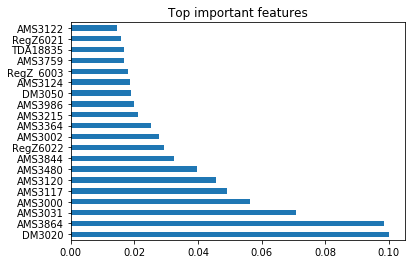

In [27]:
#rank order the variable importance
feat_importances=pd.Series(XGB.feature_importances_, index=X_train2.columns)
feat_importances.nlargest(20).plot(kind='barh')
plt.title('Top important features')
plt.show()

In [28]:
df_feat=pd.DataFrame(data=feat_importances)
df_feat.to_excel('feat_importance_xbg.xlsx')


In [29]:
#output the probability of being bad;
# train_pred=rf.predict_proba(X_train2)[:,1]
test_pred=XGB.predict_proba(X_test2)[:, 1]

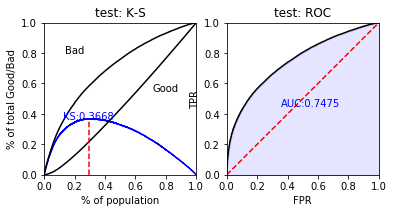

In [18]:
#performance ks and roc
import scorecardpy as sc

# train_perf=sc.perf_eva(y_train, train_pred, title='train')
test_perf=sc.perf_eva(y_test, test_pred, title='test')

In [30]:
def ks(data=None,target=None, prob=None):

    import pandas as pd

    import numpy as np

    data['target0'] = 1 - data[target]

    data['bucket'] = pd.qcut(data[prob], 10)

    grouped = data.groupby('bucket', as_index = False)

    kstable = pd.DataFrame()

    kstable['min_score'] = grouped.min()[prob]

    kstable['max_score'] = grouped.max()[prob]

    
    kstable['events']   = grouped.sum()[target]

    kstable['nonevents'] = grouped.sum()['target0']
    
    kstable = kstable.sort_values(by="min_score", ascending=False).reset_index(drop = True)
    
#     kstable['cumevents']=  kstable.events.cumsum()
#     kstable['cumnonevents']= kstable.nonevents.cumsum()
#     kstable['totevents']= kstable.events.sum()
    kstable['total']= kstable.events+kstable.nonevents
    
    kstable['event_rate']= (kstable.events/kstable.total).apply('{:.2%}'.format)
    kstable['nonevent_rate']= (kstable.nonevents/kstable.total).apply('{:.2%}'.format)
    
    kstable['% events'] = (kstable.events / kstable.events.sum()).apply('{:.2%}'.format)

    kstable['% nonevents'] = (kstable.nonevents / kstable.nonevents.sum()).apply('{:.2%}'.format)

    
    kstable['% cum_events']= (kstable.events / kstable.events.sum()).cumsum()

    kstable['% cum_nonevents']= (kstable.nonevents / kstable.nonevents.sum()).cumsum()
    
    
    kstable['KS'] = np.round(kstable['% cum_events']-kstable['% cum_nonevents'], 3) * 100

    kstable['KS']=np.abs(kstable['KS'])
    
    
    #Formating

    kstable['% cum_events']= kstable['% cum_events'].apply('{:.2%}'.format)

    kstable['% cum_nonevents']= kstable['% cum_nonevents'].apply('{:.2%}'.format)

    kstable.index = range(1,11)

    kstable.index.rename('Decile', inplace=True)

    pd.set_option('display.max_columns', None)

    print(kstable)

    

     #Display KS

    from colorama import Fore

    print(Fore.RED + "KS is " + str(max(kstable['KS']))+"%"+ " at decile " + str((kstable.index[kstable['KS']==max(kstable['KS'])][0])))

    return(kstable)



#  from common_functions import ks

In [32]:
#run the validation on test data
# from common_functions import ks
import pandas as pd

#merge only the test dataset
y_test_hat=test_pred

#convert ndarray to a dataframe, so that it can merge with true y in the merge statement

y_test_hat_df=pd.DataFrame(data=y_test_hat, columns=['Y_hats'], index=X_test2.index.copy())

df_out=pd.merge(y_test, y_test_hat_df, how='left', left_index=True, right_index=True)
ks_test=ks(data=df_out, target='good_perf', prob='Y_hats')

        min_score  max_score   events  nonevents    total event_rate  \
Decile                                                                 
1        0.926487   0.988143  12051.0      805.0  12856.0     93.74%   
2        0.907939   0.926484  11789.0     1066.0  12855.0     91.71%   
3        0.889666   0.907937  11492.0     1363.0  12855.0     89.40%   
4        0.869574   0.889656  11321.0     1534.0  12855.0     88.07%   
5        0.845985   0.869573  11004.0     1851.0  12855.0     85.60%   
6        0.815949   0.845983  10665.0     2191.0  12856.0     82.96%   
7        0.773435   0.815949  10352.0     2503.0  12855.0     80.53%   
8        0.704300   0.773429   9600.0     3255.0  12855.0     74.68%   
9        0.561222   0.704298   8327.0     4528.0  12855.0     64.78%   
10       0.041707   0.561200   4540.0     8316.0  12856.0     35.31%   

       nonevent_rate % events % nonevents % cum_events % cum_nonevents    KS  
Decile                                                  

In [21]:
ks_test.to_excel('gen3_ks_xbg.xlsx')

!aws s3 cp gen3_ks_xbg.xlsx s3://mf-ml-ds/gen3_model/output/

upload: ./gen3_ks_xbg.xlsx to s3://mf-ml-ds/gen3_model/output/gen3_ks_xbg.xlsx


In [33]:
#apply scorecard to validation dataset;
df_val=pd.read_csv('s3://mf-ml-ds/gen3_model/source/gen3_val.csv')
df_val.shape

(184010, 85)

In [34]:
df_val.loc[df_val['final_bad_perf'] == 0, 'good_perf'] = 1
df_val.loc[df_val['final_bad_perf'] == 1, 'good_perf'] = 0


In [35]:
df_val=df_val.drop(['final_bad_perf'], axis=1)

In [36]:
df_val=df_val.fillna(0)
y_val=df_val.loc[: ,'good_perf']


X_val=df_val.loc[: , ~df_val.columns.isin(['good_perf',"AMS3202","archiveattribute24","AMS3610","AMS3800","DM3123"])]

val_pred=XGB.predict_proba(X_val)[:, 1]

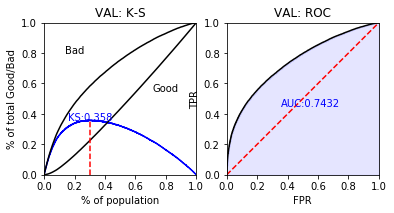

In [25]:
import scorecardpy as sc
val_perf=sc.perf_eva(y_val, val_pred, title='VAL')

In [38]:
#run the validation on test data
import pandas as pd

#merge only the test dataset
y_val_hat=val_pred

#convert ndarray to a dataframe, so that it can merge with true y in the merge statement

y_val_hat_df=pd.DataFrame(data=y_val_hat, columns=['Y_hats'], index=X_val.index.copy())

df_out=pd.merge(y_val, y_val_hat_df, how='left', left_index=True, right_index=True)
ks_val=ks(data=df_out, target='good_perf', prob='Y_hats')

        min_score  max_score   events  nonevents    total event_rate  \
Decile                                                                 
1        0.926749   0.986864  17250.0     1151.0  18401.0     93.74%   
2        0.908031   0.926748  16871.0     1530.0  18401.0     91.69%   
3        0.889814   0.908031  16479.0     1922.0  18401.0     89.55%   
4        0.869692   0.889813  16083.0     2318.0  18401.0     87.40%   
5        0.846379   0.869691  15780.0     2621.0  18401.0     85.76%   
6        0.816119   0.846379  15309.0     3092.0  18401.0     83.20%   
7        0.773918   0.816116  14808.0     3593.0  18401.0     80.47%   
8        0.706229   0.773918  13968.0     4433.0  18401.0     75.91%   
9        0.563549   0.706228  12136.0     6265.0  18401.0     65.95%   
10       0.037578   0.563545   6538.0    11863.0  18401.0     35.53%   

       nonevent_rate % events % nonevents % cum_events % cum_nonevents    KS  
Decile                                                  

In [27]:
ks_val.to_excel('gen3_val_ks_xbg.xlsx')

!aws s3 cp gen3_val_ks_xbg.xlsx s3://mf-ml-ds/gen3_model/output/

upload: ./gen3_val_ks_xbg.xlsx to s3://mf-ml-ds/gen3_model/output/gen3_val_ks_xbg.xlsx


In [23]:
#establish baseline for PSI check 
# y_val_hat_df.reset_index(drop=True, inplace=True)
# y_val_hat_df.to_excel('../propensity_to_fund/model monitor/ppfbaseline_xgb2.xlsx', index=False)

In [45]:
#apply scorecard to oot dataset;
df_oot=pd.read_csv('s3://mf-ml-ds/gen3_model/source/gen3_oot.csv')
df_oot.head()



,final_bad_perf,archiveattribute10,archiveattribute13,archiveattribute21,archiveattribute22,archiveattribute24,AMS3000,AMS3002,AMS3017,AMS3023,AMS3025,AMS3031,AMS3101,AMS3117,AMS3120,AMS3122,AMS3124,AMS3174,AMS3175,AMS3183,AMS3184,AMS3190,AMS3191,AMS3192,AMS3202,AMS3215,AMS3268,AMS3276,AMS3364,AMS3386,AMS3392,AMS3422,AMS3435,AMS3442,AMS3480,AMS3540,AMS3545,AMS3546,AMS3557,AMS3610,AMS3743,AMS3752,AMS3755,AMS3757,AMS3759,AMS3797,AMS3800,AMS3844,AMS3861,AMS3864,AMS3924,AMS3943,AMS3958,AMS3962,AMS3986,TDA01425,TDA02555,TDA04553,TDA15125,TDA18625,TDA18835,TDA18925,TDA32635,TDA35723,TDA39534,TDA41543,ATTR_6503,ATTR_6512,ATTR_6528,ATTR_6544,ATTR_6633,ATTR_6638,ATTR_6646,DM3020,DM3050,DM3051,DM3059,DM3063,DM3084,DM3123,RegZ_6003,RegZ6021,RegZ6022,RegZ6023,RegZ6040
0,1,0,0,0,0,0,3.0,4.0,0.25,0.5,1.0,1.0,0.0,NaN,8.0,8.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,0.0,NaN,0.0,NaN,NaN,0.0,NaN,1.0,NaN,0.0,0.0,0.0,NaN,9.0,1.0,8.0,NaN,NaN,NaN,NaN,1.000,0.0,1.000,0.0,0.0,0.0,0.0,NaN,0.67,NaN,NaN,0.0,0.00,NaN,300.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.0,1.0,NaN,1.0,NaN,1.00,NaN,NaN,NaN,NaN,NaN,0.0
1,1,0,60,0,0,0,0.0,3.0,0.00,0.0,NaN,NaN,1.0,194.0,498.0,57.0,72.0,NaN,0.0,NaN,NaN,0.0,NaN,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,494.0,9.0,0.0,0.0,NaN,NaN,NaN,0.000,0.0,1.000,0.0,0.0,0.0,0.0,0.0,0.14,NaN,NaN,0.0,0.19,0.07,149.0,-1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.0,2.0,11.0,NaN,NaN,NaN,0.0,NaN,NaN,444.0,17477.0,0.0
2,0,1,29,0,0,0,2.0,10.0,0.00,0.2,1.0,2.0,2.0,NaN,51.0,5.0,26.0,NaN,0.0,NaN,NaN,NaN,NaN,0.0,NaN,1.0,6.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,3.0,1.0,0.0,1.0,0.0,NaN,407.0,5.0,0.0,0.0,1.0,0.0,NaN,0.250,0.0,0.750,NaN,0.0,NaN,1.0,0.0,0.43,NaN,NaN,0.0,0.21,0.20,90.0,NaN,24.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,8.0,2.0,16.0,0.0,NaN,0.00,NaN,280.0,6155.0,403.0,NaN,0.0
3,1,0,0,0,0,0,7.0,12.0,0.00,0.5,0.0,1.0,0.0,NaN,8.0,4.0,8.0,33009.0,9.0,NaN,NaN,NaN,NaN,0.0,30596.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,NaN,0.0,0.0,NaN,71.0,10.0,1.0,1.0,NaN,NaN,NaN,0.300,NaN,1.000,NaN,0.0,NaN,0.0,0.0,0.79,NaN,NaN,304.0,0.93,NaN,36.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.0,NaN,2.0,NaN,0.0,0.00,NaN,NaN,NaN,12.0,NaN,0.0
4,0,1,3,0,0,0,1.0,4.0,0.00,0.0,NaN,NaN,0.0,NaN,143.0,2.0,2.0,NaN,0.0,0.0,NaN,0.0,NaN,2.0,NaN,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,NaN,245.0,9.0,0.0,1.0,NaN,NaN,NaN,0.143,NaN,0.929,NaN,0.0,NaN,0.0,0.0,0.28,NaN,NaN,0.0,0.00,NaN,96.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,10.0,NaN,1.0,0.08,NaN,NaN,NaN,833.0,NaN,0.0


In [46]:
df_oot.loc[df_oot['final_bad_perf'] == 0, 'good_perf'] = 1
df_oot.loc[df_oot['final_bad_perf'] == 1, 'good_perf'] = 0


In [55]:
df_oot=df_oot.drop(['final_bad_perf'], axis=1)

In [56]:
df_oot['good_perf'].value_counts()

1.0    216160
0.0     37473
Name: good_perf, dtype: int64

In [57]:
df_oot=df_oot.fillna(0)

In [58]:
y_oot=df_oot.loc[: ,'good_perf']

X_oot=df_oot.loc[: , ~df_oot.columns.isin(["good_perf","AMS3202","archiveattribute24","AMS3610","AMS3800","DM3123"])]


In [59]:
# X_oot2=X_oot.drop(["tot_past_due_amt_all_open"], axis=1)
oot_pred=XGB.predict_proba(X_oot)[:, 1]


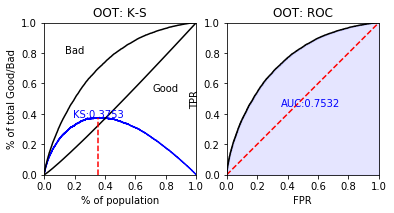

In [51]:
oot_perf=sc.perf_eva(y_oot, oot_pred, title='OOT')

In [60]:
#merge only the validation dataset
y_oot_hat=oot_pred

#convert ndarray to a dataframe, so that it can merge with true y in the merge statement

y_oot_hat_df=pd.DataFrame(data=y_oot_hat, columns=['Y_hats'], index=X_oot.index.copy())

df_out=pd.merge(y_oot, y_oot_hat_df, how='left', left_index=True, right_index=True)

ks_oot=ks(data=df_out, target='good_perf', prob='Y_hats')

        min_score  max_score   events  nonevents    total event_rate  \
Decile                                                                 
1        0.937173   0.986836  24645.0      719.0  25364.0     97.17%   
2        0.921629   0.937173  24198.0     1165.0  25363.0     95.41%   
3        0.906774   0.921628  23834.0     1529.0  25363.0     93.97%   
4        0.890883   0.906774  23517.0     1846.0  25363.0     92.72%   
5        0.872414   0.890882  23110.0     2253.0  25363.0     91.12%   
6        0.849056   0.872412  22573.0     2791.0  25364.0     89.00%   
7        0.817779   0.849055  21995.0     3368.0  25363.0     86.72%   
8        0.768656   0.817778  20997.0     4366.0  25363.0     82.79%   
9        0.665362   0.768655  18925.0     6438.0  25363.0     74.62%   
10       0.038470   0.665337  12366.0    12998.0  25364.0     48.75%   

       nonevent_rate % events % nonevents % cum_events % cum_nonevents    KS  
Decile                                                  

In [34]:
#export the KS table to an excel file
ks_oot.to_excel('gen3_oot_ks_xgb.xlsx')
!aws s3 cp gen3_oot_ks_xgb.xlsx s3://mf-ml-ds/gen3_model/output/

upload: ./gen3_oot_ks_xgb.xlsx to s3://mf-ml-ds/gen3_model/output/gen3_oot_ks_xgb.xlsx


In [61]:
import _pickle as cpickle
with open('gen3_xgb_model_v2', 'wb') as f:
    cpickle.dump(XGB, f)
    
    


In [62]:
# #Copy from SG Notebook  to S3  
!aws s3 cp  gen3_xgb_model_v2 s3://mf-ml-ds/gen3_model/final_model/
!rm gen3_xgb_model_v2


upload: ./gen3_xgb_model_v2 to s3://mf-ml-ds/gen3_model/final_model/gen3_xgb_model_v2


In [38]:
def psi(bench, comp, group):
    ben_len=len(bench)
    comp_len=len(comp)
    bench.sort()
    comp.sort()
 
    psitable=pd.DataFrame(columns = ['lowercut', 'uppercut', 'ben_cnt','ben_pct','comp_cnt','comp_pct','pct_diff','info_odds','psi'])
    ten_split = np.array_split(bench, group)
    for i in range(1,group+1):
        n = len(ten_split[i-1])
        lowercut=bench[(i-1)*n]
        ben_cnt=n
        
        if i<group:
            uppercut=bench[(i*n-1)]
        else:
            uppercut=max(bench[-1],comp[-1])
        comp_cnt= len([i for i in comp if i >= lowercut and i<=uppercut])
        ben_pct=(ben_cnt+0.0)/ben_len
        comp_pct=(comp_cnt+0.0)/comp_len
        pct_diff=ben_pct-comp_pct
        info_odds=math.log(ben_pct/comp_pct)
        psi = pct_diff * info_odds
        groupentry = {'lowercut':lowercut,'uppercut':uppercut,'ben_cnt':ben_cnt,'ben_pct':ben_pct ,\
                      'comp_cnt':comp_cnt,'comp_pct':comp_pct,'pct_diff':pct_diff,'info_odds':info_odds ,'psi':psi}
        psitable = psitable.append( groupentry, ignore_index=True)
         
    psis=sum(psitable["psi"])
    lastentry = {'psi':psis}
    psitable = psitable.append(lastentry, ignore_index=True)
    print (psitable.iloc[0:10,:])
    from colorama import Fore
    print(Fore.RED + "PSI is " + str(psis))
    return (psitable)

In [39]:
#calculate PSI for score;
import math
psitable=psi(test_pred, oot_pred, group=10)

   lowercut  uppercut  ben_cnt   ben_pct  comp_cnt  comp_pct  pct_diff  \
0  0.001020  0.013153   7526.0  0.100011    6747.0  0.056617  0.043394   
1  0.013155  0.022002   7526.0  0.100011   11148.0  0.093548  0.006463   
2  0.021999  0.032097   7525.0  0.099997   13478.0  0.113100 -0.013103   
3  0.032097  0.044104   7525.0  0.099997   14698.0  0.123337 -0.023340   
4  0.044106  0.058637   7525.0  0.099997   14274.0  0.119779 -0.019782   
5  0.058637  0.077332   7525.0  0.099997   13978.0  0.117296 -0.017298   
6  0.077335  0.101764   7525.0  0.099997   12917.0  0.108392 -0.008395   
7  0.101769  0.137857   7525.0  0.099997   12298.0  0.103198 -0.003201   
8  0.137881  0.200559   7525.0  0.099997   11024.0  0.092507  0.007490   
9  0.200560  0.643864   7525.0  0.099997    8591.0  0.072091  0.027906   

   info_odds       psi  
0   0.568966  0.024689  
1   0.066804  0.000432  
2  -0.123128  0.001613  
3  -0.209780  0.004896  
4  -0.180509  0.003571  
5  -0.159554  0.002760  
6  -0.0806